## Initial dev work for the VAE approach
* Mon 06-Aug
* I've got a very basic version of the VAE training on VCTK-22
* Set it up in PyCharm; have now set it off on aws-spot
* I'll leave it running for a number of epochs to track the training losses
* Not sure about the relative scales of the losses... MSE is much bigger? Sums vs. means? Reconstruction error: MSE vs. cross-entropy?
* May need to add in KL Annealing as per the VAELoop paper, although I'm still not sure they've got the lambda parameter on the correct term in their paper. Need to cross-reference with other sources


** Tue 07-Aug **
* Unfortunately died overnight so I'm nowhere near where I need to be
* So far, the KLD has just kept falling to tiny levels. MSE is also falling too, so the model is learning something.
* The embeddings all appear to be the same, based on a quick look... so that's not great
* But in the last few epochs KLD has been increasing. I'm going to train a few more to see if it gets any higher, and if so I can look at the embeddings again
* If not, I'll add KL annealing to see how the KLD looks in that case


In [1]:
# needs to run in the vae branch
import os
os.chdir('/home/ubuntu/msc-project-vae/')

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from tqdm import tqdm

from model import Loop, MaskedMSE

from utils import generate_merlin_wav, wrap

from data import NpzFolder, NpzLoader

import notebook_utils as nu

from sklearn.decomposition import PCA

from sklearn.manifold import TSNE

import sklearn.metrics.pairwise as pw

from IPython.display import Audio
import IPython.display

%matplotlib inline

%load_ext autoreload
%autoreload 2

/usr/local/lib/python2.7/dist-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [4]:
import training_monitor as tm
import eval_curves as ec

In [5]:
os.getcwd()

'/home/ubuntu/msc-project-vae'

### 1) Initial dev: Just getting it all to work
* Does it run without errors?
* Does the MSE error train at all? How does it compare to the baseline sims?

```python
python train.py --expName='vctk-us-vae-test' --data='/home/ubuntu/loop/data/vctk' --noise=4 --seq-len=100 --epochs=90 --nspk=22
```

In [6]:
tm_base = tm.TrainingMonitor('vctk-us-vae-test.csv', exp_name='vctk-us-vae-test', path="/home/ubuntu/msc-project-vae/training_logs")

In [8]:
tm_base.disp()

,epoch,mcd,train_loss,train_loss_kld,train_loss_mse,update_time,valid_loss,valid_loss_kld,valid_loss_mse
0,1,NaN,62.124591,0.004600,62.119991,06-Aug-2018 17:53:32,62.661839,0.004696,62.657143
1,2,NaN,58.659683,0.003617,58.656066,06-Aug-2018 18:01:59,59.442349,0.003649,59.438700
2,3,NaN,58.539935,0.008832,58.531102,06-Aug-2018 18:10:24,58.375477,0.008897,58.366580
3,4,NaN,57.609640,0.007919,57.601721,06-Aug-2018 18:18:45,58.205546,0.008001,58.197544
4,5,NaN,56.740567,0.007572,56.732994,06-Aug-2018 18:27:06,57.330415,0.007605,57.322810
5,6,NaN,57.157212,0.028302,57.128910,06-Aug-2018 18:35:37,57.307774,0.028186,57.279588
6,7,NaN,55.091292,0.003303,55.087988,06-Aug-2018 18:43:59,55.859772,0.003315,55.856456
7,8,NaN,53.730494,0.002282,53.728212,06-Aug-2018 18:52:23,54.389590,0.002296,54.387295
8,9,NaN,53.316485,0.003467,53.313018,06-Aug-2018 19:00:46,53.720902,0.003490,53.717413
9,10,NaN,51.960594,0.004882,51.955712,06-Aug-2018 19:09:12,52.143593,0.004918,52.138675


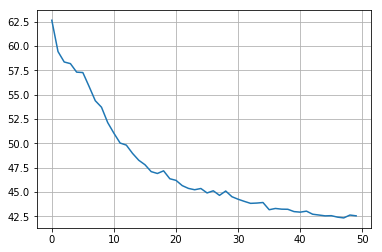

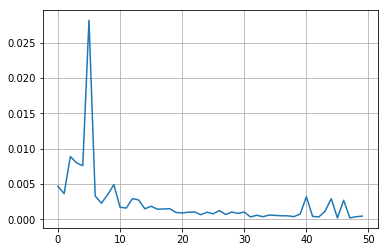

In [9]:
plt.plot(tm_base.data.valid_loss_mse)
plt.grid(True)
plt.show()

plt.plot(tm_base.data.valid_loss_kld)
plt.grid(True)
plt.show()

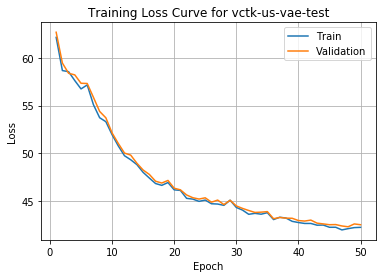

In [10]:
tm_base.plot_loss()

### v2. Anneal KL coeff from 0 to 1 over 15 epochs
* First go at KL annealing
* Starts out learning as normal, with MSE falling a bit and KLD going nuts
* But as soon as KLD gets any weight at all, it rapidly falls towards zero
* By epoch 13, the embeddings appear to be very highly correlated... typically around 99% cosine sim. But at least the male utterances do stick out on the heatmap, with male-female correlations at around 98%... so it's learning something at least
* This was using torch.renom in the embedding encoder, but not tanh, which I though was unjustified but having discussed with Jiameng seems like it could be okay
* He also said that the MSE error is effectively a log likelihood... check this out

```python
python train.py --expName='vctk-us-vae-kl-anneal-test' --data='/home/ubuntu/loop/data/vctk' --noise=4 --seq-len=100 --epochs=90 --nspk=22 --kld-annealing-epochs=15
```

In [6]:
tm_base = tm.TrainingMonitor('vctk-us-vae-kl-anneal-test.csv', exp_name='vctk-us-vae-kl-anneal-test', path="/home/ubuntu/msc-project-vae/training_logs")

In [7]:
tm_base.disp()

,epoch,update_time,train_loss,train_loss_mse,train_loss_kld,valid_loss,valid_loss_mse,valid_loss_kld,mcd
0,1,07-Aug-2018 15:50:17,61.235692,61.235692,43.811712,61.243095,61.243095,44.077875,NaN
1,2,07-Aug-2018 15:58:39,59.349135,59.349135,43.282583,59.174077,59.174077,44.185126,NaN
2,3,07-Aug-2018 16:07:03,58.218506,58.218506,43.661614,58.353726,58.353726,43.515888,NaN
3,4,07-Aug-2018 16:15:16,56.699134,56.699134,43.902421,57.190403,57.190403,44.314134,NaN
4,5,07-Aug-2018 16:23:25,56.440838,56.440838,43.323080,56.520569,56.520569,43.671358,NaN
5,6,07-Aug-2018 14:03:08,56.335673,56.334315,0.003802,56.665313,56.663952,0.003812,NaN
6,7,07-Aug-2018 14:11:29,55.153330,55.151211,0.004945,55.647721,55.645547,0.005071,NaN
7,8,07-Aug-2018 14:19:43,54.192485,54.190688,0.003595,54.776915,54.775088,0.003654,NaN
8,9,07-Aug-2018 14:28:09,53.355143,53.353737,0.002459,53.502464,53.501027,0.002515,NaN
9,10,07-Aug-2018 14:36:49,51.945162,51.943835,0.002065,52.410645,52.409302,0.002088,NaN


### v3. KL annealing where initial epochs have KL weight=0, and where it only increases to a modest value at the end
* Unfortunately I called this the same thing, so it's overwritten the earlier results... doh

```python
python train.py --expName='vctk-us-vae-kl-anneal-test' --data='/home/ubuntu/loop/data/vctk' --noise=4 --seq-len=100 --epochs=90 --nspk=22 --kld-annealing-epochs=15
```

In [251]:
tm_base = tm.TrainingMonitor('vctk-us-vae-kl-anneal-test.csv', exp_name='vctk-us-vae-kl-anneal-test', path="/home/ubuntu/msc-project-vae/training_logs")

In [252]:
tm_base.disp()

,epoch,update_time,train_loss,train_loss_mse,train_loss_kld,valid_loss,valid_loss_mse,valid_loss_kld,mcd
0,1,07-Aug-2018 15:50:17,61.235692,61.235692,43.811712,61.243095,61.243095,44.077875,NaN
1,2,07-Aug-2018 15:58:39,59.349135,59.349135,43.282583,59.174077,59.174077,44.185126,NaN
2,3,07-Aug-2018 16:07:03,58.218506,58.218506,43.661614,58.353726,58.353726,43.515888,NaN
3,4,07-Aug-2018 16:15:16,56.699134,56.699134,43.902421,57.190403,57.190403,44.314134,NaN
4,5,07-Aug-2018 16:23:25,56.440838,56.440838,43.323080,56.520569,56.520569,43.671358,NaN
5,6,07-Aug-2018 16:31:44,55.698569,55.698569,43.409624,56.044607,56.044607,43.379572,NaN
6,7,07-Aug-2018 16:40:13,54.554635,54.554635,43.106806,54.755905,54.755905,43.122431,NaN
7,8,07-Aug-2018 16:48:47,53.524417,53.524417,43.619570,53.757834,53.757834,43.105411,NaN
8,9,07-Aug-2018 16:57:12,52.005348,52.005348,42.838510,52.246786,52.246786,43.088426,NaN
9,10,07-Aug-2018 17:06:06,51.914295,51.914295,43.560035,52.069043,52.069043,43.970922,NaN


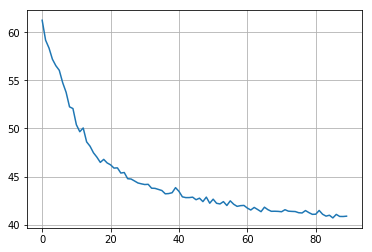

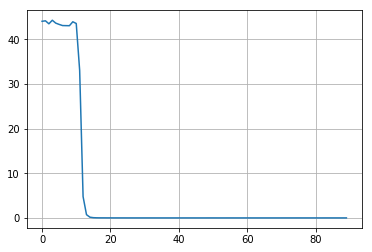

In [253]:
plt.plot(tm_base.data.valid_loss_mse)
plt.grid(True)
plt.show()

plt.plot(tm_base.data.valid_loss_kld)
plt.grid(True)
plt.show()

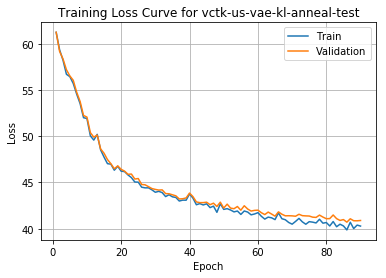

In [254]:
tm_base.plot_loss()

### v4. With tanh and renorm taken off
* ...does this learn more sensible variance values?
* If so, can experiment with annealing-epochs and kld-lambda balance (kld-lambda should be much lower?)
* Initially tried annealing-initial-epochs=0 as before, but the KLD was going crazy (40k!) so I decided to start over with no initial epochs
* So the KLD is still much too powerful and crushes the distribution into a mush. I ran up to 12 epochs but that wasn't good enough to hear any speech, and already the distribution was completely squished,
* Will try again with a much lower lambda and longer annealing period...

```python
python train.py --expName='vctk-us-vae-kl-anneal-notanhrenorm' --data='/home/ubuntu/loop/data/vctk' --noise=4 --seq-len=100 --epochs=90 --nspk=22 --kld-annealing-epochs=15 --kld-lambda=0.1 --kld-annealing-initial-epochs=0
```

In [191]:
tm_base = tm.TrainingMonitor('vctk-us-vae-kl-anneal-notanhrenorm.csv', exp_name='vctk-us-vae-kl-anneal-noranhrenorm', path="/home/ubuntu/msc-project-vae/training_logs")

In [192]:
tm_base.disp()

,epoch,update_time,train_loss,train_loss_mse,train_loss_kld,valid_loss,valid_loss_mse,valid_loss_kld,mcd
0,1,08-Aug-2018 12:33:31,54.666812,54.666812,38609.967685,54.920261,54.920261,39103.576349,NaN
1,2,08-Aug-2018 12:41:49,58.959162,58.161133,111.724073,59.090290,58.277028,113.856768,NaN
2,3,08-Aug-2018 12:50:06,57.864179,57.339755,36.709712,58.064671,57.467470,41.804109,NaN
3,4,08-Aug-2018 12:58:30,57.392201,56.956035,20.354385,57.980336,57.496893,22.560673,NaN
4,5,08-Aug-2018 13:06:50,56.215409,56.072935,4.986618,56.822826,56.631809,6.685635,NaN
5,6,08-Aug-2018 13:15:06,55.845295,55.743131,2.860576,56.013094,55.886252,3.551598,NaN
6,7,08-Aug-2018 13:23:28,54.353792,54.308839,1.048898,54.897393,54.845724,1.205632,NaN
7,8,08-Aug-2018 13:31:53,53.817882,53.799155,0.374541,53.823181,53.801819,0.427235,NaN
8,9,08-Aug-2018 13:40:07,51.778115,51.773932,0.073187,52.178521,52.172969,0.097135,NaN
9,10,08-Aug-2018 13:48:23,51.093354,51.091662,0.026306,51.542957,51.541186,0.027547,NaN


### 5. with much lower KLD lambda
* 

```python
python train.py --expName='vctk-us-vae-kl-anneal-notanhrenorm-lambda0.01' --data='/home/ubuntu/loop/data/vctk' --noise=4 --seq-len=100 --epochs=90 --nspk=22 --kld-annealing-epochs=30 --kld-lambda=0.01 --kld-annealing-initial-epochs=0
```

In [127]:
tm_base = tm.TrainingMonitor('vctk-us-vae-kl-anneal-notanhrenorm-lambda0.csv', exp_name='vctk-us-vae-kl-anneal-noranhrenorm-lambda0.01', path="/home/ubuntu/msc-project-vae/training_logs")

In [128]:
tm_base.disp()

,epoch,update_time,train_loss,train_loss_mse,train_loss_kld,valid_loss,valid_loss_mse,valid_loss_kld,mcd
0,1,08-Aug-2018 14:22:54,53.959192,53.959192,39622.699929,54.540753,54.540753,39721.511364,NaN
1,2,08-Aug-2018 14:31:24,55.402688,54.499746,2618.530251,55.163283,54.202186,2787.183316,NaN
2,3,08-Aug-2018 14:39:49,54.388402,53.022163,1981.047053,54.665855,53.232605,2078.212769,NaN
3,4,08-Aug-2018 14:48:21,53.329059,52.534876,767.709434,53.725741,52.863395,833.602020,NaN
4,5,08-Aug-2018 14:56:51,52.453244,51.644600,586.266607,52.518906,51.542237,708.085224,NaN
5,6,08-Aug-2018 15:05:25,51.744084,50.525910,706.541118,51.549126,50.261817,746.639091,NaN
6,7,08-Aug-2018 15:13:50,50.800509,49.809262,479.102500,51.307757,50.340530,467.493300,NaN
7,8,08-Aug-2018 15:22:08,49.890540,48.993349,371.693481,50.450329,49.365418,449.463268,NaN
8,9,08-Aug-2018 15:30:37,49.138190,48.170143,350.916745,49.477761,48.508073,351.511948,NaN
9,10,08-Aug-2018 15:39:17,48.666391,47.771028,288.505790,48.958318,48.098201,277.148578,NaN


If this doesn't work, could consider hacking in the model weights from an old checkpoint and adding in KLD loss from there? Not ideal because the embeddings don't have the tanh etc? But could we make it work?

#### Phase 2: noise 2
* Loss was going down in phase 1, and KLD has stabilised, but was still much too low
* See if phase 2 helps

```python
python train.py --expName='vctk-us-vae-kl-anneal-notanhrenorm-lambda001-noise-2' --data='/home/ubuntu/loop/data/vctk' --noise=2 --seq-len=300 --epochs=90 --nspk=22 --kld-annealing-epochs=30 --kld-lambda=0.01 --kld-annealing-initial-epochs=0 --checkpoint='checkpoints/vctk-us-vae-kl-anneal-notanhrenorm-lambda0.001/bestmodel.pth'
```

In [187]:
tm_base = tm.TrainingMonitor('vctk-us-vae-kl-anneal-notanhrenorm-lambda001-noise-2.csv', exp_name='vctk-us-vae-kl-anneal-noranhrenorm-lambda001-noise-2', path="/home/ubuntu/msc-project-vae/training_logs")

In [188]:
tm_base.disp()

,epoch,update_time,train_loss,train_loss_mse,train_loss_kld,valid_loss,valid_loss_mse,valid_loss_kld,mcd
0,90,09-Aug-2018 06:50:09,33.024155,33.023225,0.093038,33.447628,33.446619,0.100868,NaN
1,91,09-Aug-2018 06:57:01,32.708159,32.707435,0.072412,33.211991,33.211108,0.088319,NaN
2,92,09-Aug-2018 07:03:52,32.381169,32.380377,0.079220,33.094900,33.094106,0.079440,NaN
3,93,09-Aug-2018 07:10:40,32.374250,32.373440,0.081017,33.043104,33.042296,0.080784,NaN
4,94,09-Aug-2018 07:17:27,32.194981,32.194358,0.062366,32.859331,32.858643,0.068795,NaN
5,95,09-Aug-2018 07:24:10,32.383804,32.383161,0.064350,32.814926,32.814230,0.069662,NaN
6,96,09-Aug-2018 07:30:39,32.249329,32.248629,0.069944,32.802001,32.801311,0.069076,NaN
7,97,09-Aug-2018 07:36:59,32.111353,32.110830,0.052227,32.828484,32.827957,0.052738,NaN
8,98,09-Aug-2018 07:43:33,32.128693,32.128026,0.066667,32.743486,32.742747,0.073905,NaN
9,99,09-Aug-2018 07:50:10,31.855950,31.855443,0.050640,32.649149,32.648576,0.057299,NaN


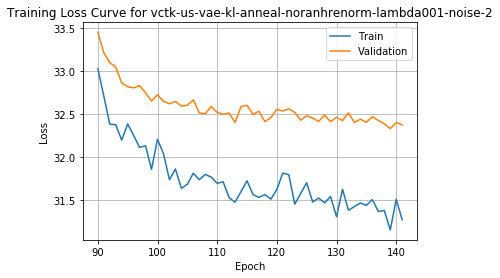

In [189]:
tm_base.plot_loss()

To try next:
* Use only 32/62 dimensions and project up
* Train with zero KLD lambda for the first 90 epochs and then add it in from there

## With 64-dim speaker space
* Reduced speaker embedding space to 64-dim, with a 64->256 dim linear project layer


```python
python train.py --expName='vctk-us-vae-64-test' --data='/home/ubuntu/loop/data/vctk' --noise=4 --seq-len=100 --epochs=90 --nspk=22 --kld-annealing-epochs=30 --kld-lambda=0.01 --kld-annealing-initial-epochs=0 --embedding-size=64
```

In [137]:
tm_base = tm.TrainingMonitor('vctk-us-vae-64-test.csv', exp_name='vctk-us-vae-kl-64-test', path="/home/ubuntu/msc-project-vae/training_logs")

In [138]:
tm_base.disp()

,epoch,update_time,train_loss,train_loss_mse,train_loss_kld,valid_loss,valid_loss_mse,valid_loss_kld,mcd
0,1,09-Aug-2018 12:59:59,53.871292,53.871292,12873.897017,53.907866,53.907866,13033.206143,NaN
1,2,09-Aug-2018 13:08:20,52.163749,51.078057,3148.507369,52.411260,51.298399,3227.294744,NaN
2,3,09-Aug-2018 13:16:47,50.416764,49.274359,1656.487282,50.050440,48.892718,1678.696578,NaN
3,4,09-Aug-2018 13:25:16,48.399526,47.486482,882.608909,48.801991,47.789291,978.943237,NaN
4,5,09-Aug-2018 13:33:48,47.205923,46.292990,661.876598,47.172545,46.211811,696.532399,NaN
5,6,09-Aug-2018 13:42:04,46.293702,45.632953,383.234344,46.454076,45.795321,382.077781,NaN
6,7,09-Aug-2018 13:50:14,45.563541,45.135009,207.124119,45.898544,45.448599,217.473451,NaN
7,8,09-Aug-2018 13:58:38,45.788992,45.368175,174.338597,46.054899,45.627445,177.087488,NaN
8,9,09-Aug-2018 14:07:01,45.580593,45.279890,109.004917,45.520215,45.243069,100.465587,NaN
9,10,09-Aug-2018 14:15:32,46.013627,45.884102,41.735592,45.930576,45.774198,50.388407,NaN


KLD still going very low, and embeddings still getting unreasonably squashed... I'm pretty sure there was a bug in that KLD was being done with torch.sum as per the PyTorch demo. This is summing over the batch rather than averaging, which I guess was okay in the demo because they were also summing rather than averaging cross-entropy. Here, we are using MSE across the batch so should definitely average KLD over the batch too. But what about over the dimensions? Our MSE is summed over the 63 feature dimensions. Currently KLD is summed as well. But I think perhaps it should be averaged over the latent dimensions too? Still not entirely sure

### Now using torch.mean
* i.e. averaging across the batch and the dimensions of the embedding space
* Now setting lambda = 1... shouldn't need the hack any more!
* For now I'm doing a test setting where I use no initial epochs and use 30 annealing epochs. Let's see how this one goes, and then consider restarting with different settings (could definitely consider turning it off/down for the first 90 epochs while noise is high to prevent learning the average voice?)

```python
python train.py --expName='vctk-us-vae-64-mean' --data='/home/ubuntu/loop/data/vctk' --noise=4 --seq-len=100 --epochs=90 --nspk=22 --kld-annealing-epochs=30 --kld-lambda=1.0 --kld-annealing-initial-epochs=0 --embedding-size=64
```

In [112]:
tm_base = tm.TrainingMonitor('vctk-us-vae-64-mean.csv', exp_name='vctk-us-vae-64-mean', path="/home/ubuntu/msc-project-vae/training_logs")

In [113]:
tm_base.disp()

,epoch,update_time,train_loss,train_loss_mse,train_loss_kld,valid_loss,valid_loss_mse,valid_loss_kld,mcd
0,1,09-Aug-2018 16:44:19,53.536080,53.536080,2.984068,53.848166,53.848166,3.103138,NaN
1,2,09-Aug-2018 16:52:43,50.171610,50.068154,3.000235,50.587616,50.482052,3.061365,NaN
2,3,09-Aug-2018 17:01:16,46.765507,46.539092,3.283020,47.212189,46.987046,3.264568,NaN
3,4,09-Aug-2018 17:09:43,45.062240,44.724558,3.264259,45.311206,44.971080,3.287885,NaN
4,5,09-Aug-2018 17:18:15,44.694698,44.303958,2.832874,44.770977,44.377303,2.854134,NaN
5,6,09-Aug-2018 17:26:46,43.832924,43.340666,2.855093,44.070807,43.573571,2.883966,NaN
6,7,09-Aug-2018 17:35:16,43.740022,43.167571,2.766844,43.741907,43.164566,2.790480,NaN
7,8,09-Aug-2018 17:43:28,43.485023,42.946529,2.230905,43.573913,43.031055,2.248981,NaN
8,9,09-Aug-2018 17:51:57,42.845075,42.188687,2.379408,43.008625,42.339161,2.426807,NaN
9,10,09-Aug-2018 18:00:34,42.575781,41.883186,2.231694,42.889553,42.190472,2.252596,NaN


#### Phase 2

```python
python train.py --expName='vctk-us-vae-64-mean-noise-2' --data='/home/ubuntu/loop/data/vctk' --noise=2 --seq-len=300 --epochs=90 --nspk=22 --kld-annealing-epochs=30 --kld-lambda=1.0 --kld-annealing-initial-epochs=0 --embedding-size=64 --checkpoint='checkpoints/vctk-us-vae-64-mean/bestmodel.pth'
```

In [276]:
tm_base = tm.TrainingMonitor('vctk-us-vae-64-mean-noise-2.csv', exp_name='vctk-us-vae-64-mean-noise-2', path="/home/ubuntu/msc-project-vae/training_logs")

In [277]:
tm_base.disp()

,epoch,update_time,train_loss,train_loss_mse,train_loss_kld,valid_loss,valid_loss_mse,valid_loss_kld,mcd
0,90,10-Aug-2018 06:35:56,31.525360,31.169396,0.355963,32.921259,32.545325,0.375934,NaN
1,91,10-Aug-2018 06:42:48,31.100312,30.747183,0.353129,32.449836,32.099143,0.350694,NaN
2,92,10-Aug-2018 06:49:43,30.964881,30.645285,0.319596,32.317386,31.972275,0.345112,NaN
3,93,10-Aug-2018 06:56:21,30.806112,30.496106,0.310005,32.155596,31.832673,0.322923,NaN
4,94,10-Aug-2018 07:02:59,30.970927,30.648396,0.322531,32.256235,31.934074,0.322161,NaN
5,95,10-Aug-2018 07:09:40,30.801548,30.471470,0.330079,32.055058,31.706823,0.348235,NaN
6,96,10-Aug-2018 07:16:17,30.717178,30.429511,0.287667,31.960884,31.656651,0.304233,NaN
7,97,10-Aug-2018 07:23:00,30.793994,30.514776,0.279218,31.882264,31.579614,0.302649,NaN
8,98,10-Aug-2018 07:29:38,30.704673,30.391095,0.313578,32.031047,31.715569,0.315478,NaN
9,99,10-Aug-2018 07:36:18,30.635883,30.338221,0.297662,31.963281,31.661609,0.301672,NaN


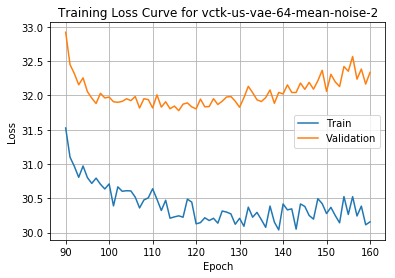

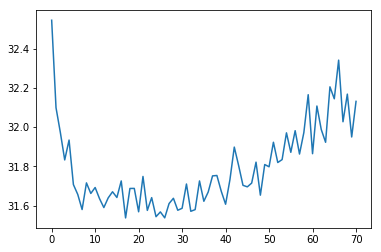

In [278]:
tm_base.plot_loss()
plt.plot(tm_base.data['valid_loss_mse'])

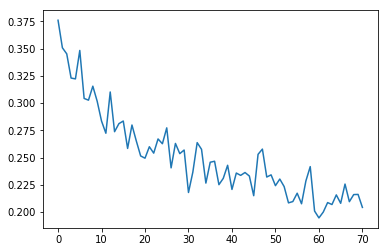

In [279]:
plt.plot(tm_base.data['valid_loss_kld'])

### Run with zero lamda to KLD for first 100 epochs
* They train from that point on with KLD loss added in
* See if it finds a better solution that way, rather than collapsing towards an average voice

```python
python train.py --expName='vctk-us-vae-64-mean-lambda-zero' --data='/home/ubuntu/loop/data/vctk' --noise=4 --seq-len=100 --epochs=90 --nspk=22 --kld-annealing-epochs=30 --kld-lambda=1.0 --kld-annealing-initial-epochs=100 --embedding-size=64
```

```python
python train.py --expName='vctk-us-vae-64-mean-lambda-zero' --data='/home/ubuntu/loop/data/vctk' --noise=4 --seq-len=100 --epochs=90 --nspk=22 --kld-annealing-epochs=30 --kld-lambda=1.0 --kld-annealing-initial-epochs=100 --embedding-size=64 --checkpoint='checkpoints/vctk-us-vae-64-mean-lambda-zero/bestmodel.pth'
```

In [6]:
tm_base = tm.TrainingMonitor('vctk-us-vae-64-mean-lambda-zero.csv', exp_name='vctk-us-vae-64-mean-lambda-zero', path="/home/ubuntu/msc-project-vae/training_logs")

In [7]:
tm_base.disp()

,epoch,update_time,train_loss,train_loss_mse,train_loss_kld,valid_loss,valid_loss_mse,valid_loss_kld,mcd
0,1,10-Aug-2018 22:26:21,54.378205,54.378205,3.077834,54.269098,54.269098,3.100858,NaN
1,2,10-Aug-2018 22:34:57,49.996472,49.996472,3.466611,50.227199,50.227199,3.484358,NaN
2,3,10-Aug-2018 22:43:30,47.724926,47.724926,3.662159,47.852564,47.852564,3.691232,NaN
3,4,10-Aug-2018 22:51:49,45.233218,45.233218,3.763002,45.244561,45.244561,3.751334,NaN
4,5,10-Aug-2018 23:00:15,43.941256,43.941256,4.116139,44.122495,44.122495,4.129894,NaN
5,6,10-Aug-2018 23:08:30,43.324713,43.324713,4.342778,43.661789,43.661789,4.318905,NaN
6,7,10-Aug-2018 23:16:54,42.751560,42.751560,4.275808,43.080194,43.080194,4.281719,NaN
7,8,10-Aug-2018 23:25:13,42.599403,42.599403,4.299483,42.677910,42.677910,4.335704,NaN
8,9,10-Aug-2018 23:33:28,42.111141,42.111141,4.485621,42.155469,42.155469,4.564237,NaN
9,10,10-Aug-2018 23:41:37,42.088065,42.088065,4.535331,42.203484,42.203484,4.602000,NaN


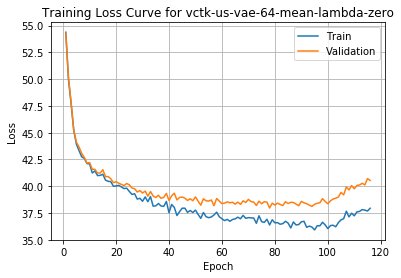

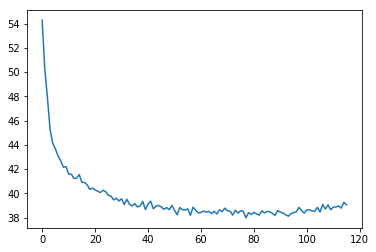

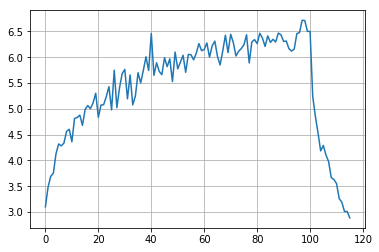

In [10]:
tm_base.plot_loss()
plt.plot(tm_base.data['valid_loss_mse'])
plt.show()

plt.plot(tm_base.data['valid_loss_kld'])
plt.grid(True)

```python
python train.py --expName='vctk-us-vae-64-mean-lambda-zero-noise-2' --data='/home/ubuntu/loop/data/vctk' --noise=2 --seq-len=300 --epochs=90 --nspk=22 --kld-annealing-epochs=30 --kld-lambda=1.0 --kld-annealing-initial-epochs=100 --embedding-size=64 --checkpoint='checkpoints/vctk-us-vae-64-mean-lambda-zero/bestmodel.pth'
```

In [15]:
tm_base = tm.TrainingMonitor('vctk-us-vae-64-mean-lambda-zero-noise-2.csv', exp_name='vctk-us-vae-64-mean-lambda-zero-noise-2', path="/home/ubuntu/msc-project-vae/training_logs")

In [16]:
tm_base.disp()

,epoch,update_time,train_loss,train_loss_mse,train_loss_kld,valid_loss,valid_loss_mse,valid_loss_kld,mcd
0,90,12-Aug-2018 08:21:59,31.072556,31.072556,6.152993,32.447924,32.447924,6.182591,NaN
1,91,12-Aug-2018 08:28:45,30.601308,30.601308,6.259957,31.938192,31.938192,6.310393,NaN
2,92,12-Aug-2018 08:35:31,30.730355,30.730355,6.580443,31.884621,31.884621,6.581672,NaN
3,93,12-Aug-2018 08:42:12,30.339023,30.339023,6.466573,31.710756,31.710756,6.441836,NaN
4,94,12-Aug-2018 08:48:56,30.485884,30.485884,6.580361,31.899496,31.899496,6.642170,NaN
5,95,12-Aug-2018 08:55:35,30.588009,30.588009,6.416215,31.713236,31.713236,6.438967,NaN
6,96,12-Aug-2018 09:02:15,30.610659,30.610659,6.314057,31.637069,31.637069,6.302784,NaN
7,97,12-Aug-2018 09:08:57,30.465487,30.465487,6.684023,31.563328,31.563328,6.663956,NaN
8,98,12-Aug-2018 09:15:40,30.201092,30.201092,6.668208,31.563994,31.563994,6.689052,NaN
9,99,12-Aug-2018 09:22:33,30.088767,30.088767,6.812597,31.616519,31.616519,6.836756,NaN


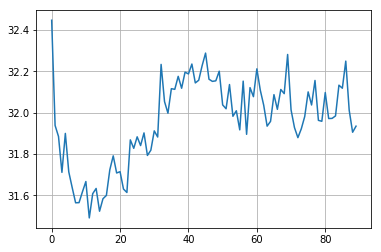

In [23]:
plt.plot(tm_base.data['valid_loss_mse'])
plt.grid(True)

### Try a sim from scratch with higher KLD - any evidence it forces disentanglement?
* Sun night 12-Aug
* Ran through to Mon evening
* Makes sense: reconstruction loss not as good, but KLD goes very low indeed

```python
python train.py --expName='vctk-us-vae-64-mean-lambda-5.0' --data='/home/ubuntu/loop/data/vctk' --noise=4 --seq-len=100 --epochs=90 --nspk=22 --kld-annealing-epochs=30 --kld-lambda=5.0 --kld-annealing-initial-epochs=0 --embedding-size=64
```

In [8]:
tm_base = tm.TrainingMonitor('vctk-us-vae-64-mean-lambda-5.csv', exp_name='vctk-us-vae-64-mean-lambda-5', path="/home/ubuntu/msc-project-vae/training_logs")

In [9]:
tm_base.disp()

,epoch,update_time,train_loss,train_loss_mse,train_loss_kld,valid_loss,valid_loss_mse,valid_loss_kld,mcd
0,1,12-Aug-2018 19:27:54,53.933787,53.933787,2.971051,54.073378,54.073378,3.063961,NaN
1,2,12-Aug-2018 19:36:15,50.938262,50.537454,2.324685,51.123509,50.722489,2.325912,NaN
2,3,12-Aug-2018 19:44:27,48.041063,47.329313,2.064074,48.354616,47.645314,2.056974,NaN
3,4,12-Aug-2018 19:52:49,46.359793,45.390634,1.873708,46.377614,45.411118,1.868558,NaN
4,5,12-Aug-2018 20:01:08,45.878065,44.855029,1.483401,46.004429,44.982169,1.482276,NaN
5,6,12-Aug-2018 20:09:25,45.701021,44.640967,1.229663,45.507256,44.454456,1.221248,NaN
6,7,12-Aug-2018 20:17:43,44.655499,43.806398,0.820798,44.563913,43.708496,0.826904,NaN
7,8,12-Aug-2018 20:25:49,44.015845,43.230478,0.650733,44.366759,43.589224,0.644243,NaN
8,9,12-Aug-2018 20:34:08,43.997073,43.204325,0.574742,44.249198,43.472016,0.563457,NaN
9,10,12-Aug-2018 20:42:21,43.507996,42.873335,0.409004,43.760549,43.090121,0.432054,NaN


```python
python train.py --expName='vctk-us-vae-64-mean-lambda-5-noise-2' --data='/home/ubuntu/loop/data/vctk' --noise=2 --seq-len=300 --epochs=90 --nspk=22 --kld-annealing-epochs=30 --kld-lambda=5.0 --kld-annealing-initial-epochs=0 --embedding-size=64 --checkpoint='checkpoints/vctk-us-vae-64-mean-lambda-5.0/bestmodel.pth'
```

In [6]:
tm_base = tm.TrainingMonitor('vctk-us-vae-64-mean-lambda-5-noise-2.csv', exp_name='vctk-us-vae-64-mean-lambda-5-noise-2', path="/home/ubuntu/msc-project-vae/training_logs")

In [7]:
tm_base.disp()

,epoch,update_time,train_loss,train_loss_mse,train_loss_kld,valid_loss,valid_loss_mse,valid_loss_kld,mcd
0,90,13-Aug-2018 09:26:24,31.603224,31.552029,0.010239,32.690883,32.636024,0.010972,NaN
1,91,13-Aug-2018 09:33:04,31.187809,31.152888,0.006984,32.449655,32.414467,0.007037,NaN
2,92,13-Aug-2018 09:39:35,31.273028,31.253332,0.003939,32.217235,32.195844,0.004278,NaN
3,93,13-Aug-2018 09:46:07,31.088431,31.075101,0.002666,32.146847,32.133590,0.002651,NaN
4,94,13-Aug-2018 09:52:36,30.978433,30.968801,0.001926,31.988396,31.979090,0.001861,NaN
5,95,13-Aug-2018 09:59:12,30.891039,30.884421,0.001323,31.990334,31.983339,0.001399,NaN
6,96,13-Aug-2018 10:05:37,30.784258,30.779524,0.000947,31.866554,31.861812,0.000948,NaN
7,97,13-Aug-2018 10:11:57,30.871830,30.868977,0.000571,31.929436,31.926134,0.000660,NaN
8,98,13-Aug-2018 10:18:30,30.432673,30.430512,0.000432,31.911857,31.909337,0.000504,NaN
9,99,13-Aug-2018 10:24:50,30.600118,30.598535,0.000317,31.889974,31.888148,0.000365,NaN


### Vary KLD lambda: 2.0
* Mon night 13-Aug
* Can we see the impact of varying the lambda? On the loss terms? On the learned mu and sigma? On the speaker recognition? On the quality of the samples? Any obvious impact on disentanglement?
* Can show the mu/sigma spread over the course of training
* Can compare terminal mu/sigma as we vary the allocation to KLD

```python
python train.py --expName='vctk-us-vae-64-mean-lambda-2' --data='/home/ubuntu/loop/data/vctk' --noise=4 --seq-len=100 --epochs=90 --nspk=22 --kld-annealing-epochs=30 --kld-lambda=2.0 --kld-annealing-initial-epochs=0 --embedding-size=64
```

In [81]:
tm_base = tm.TrainingMonitor('vctk-us-vae-64-mean-lambda-2.csv', exp_name='vctk-us-vae-64-mean-lambda-2', path="/home/ubuntu/msc-project-vae/training_logs")

In [82]:
tm_base.disp()

,epoch,update_time,train_loss,train_loss_mse,train_loss_kld,valid_loss,valid_loss_mse,valid_loss_kld,mcd
0,1,13-Aug-2018 21:30:45,54.169850,54.169850,2.968327,54.213748,54.213748,3.071774,NaN
1,2,13-Aug-2018 21:39:37,50.162995,49.971460,2.777247,50.731182,50.537060,2.814776,NaN
2,3,13-Aug-2018 21:48:20,46.967456,46.604634,2.630467,47.257492,46.889269,2.669617,NaN
3,4,13-Aug-2018 21:56:58,46.261243,45.703229,2.697066,46.261756,45.705751,2.687355,NaN
4,5,13-Aug-2018 22:05:45,45.543588,44.817355,2.632597,45.215167,44.472333,2.692776,NaN
5,6,13-Aug-2018 22:14:06,44.408789,43.702089,2.049424,44.431719,43.712530,2.085649,NaN
6,7,13-Aug-2018 22:22:28,43.790641,42.971753,1.978979,43.957856,43.135797,1.986643,NaN
7,8,13-Aug-2018 22:30:59,43.738069,42.819139,1.903495,43.910775,42.973636,1.941218,NaN
8,9,13-Aug-2018 22:39:20,43.362606,42.404041,1.737400,43.654852,42.693839,1.741834,NaN
9,10,13-Aug-2018 22:47:42,43.070814,42.140557,1.498746,43.484627,42.555483,1.496955,NaN


```python
python train.py --expName='vctk-us-vae-64-mean-lambda-2-noise-2' --data='/home/ubuntu/loop/data/vctk' --noise=2 --seq-len=300 --epochs=90 --nspk=22 --kld-annealing-epochs=30 --kld-lambda=2.0 --kld-annealing-initial-epochs=0 --embedding-size=64 --checkpoint='checkpoints/vctk-us-vae-64-mean-lambda-2/bestmodel.pth'
```

In [6]:
tm_base = tm.TrainingMonitor('vctk-us-vae-64-mean-lambda-2-noise-2.csv', exp_name='vctk-us-vae-64-mean-lambda-2-noise-2', path="/home/ubuntu/msc-project-vae/training_logs")

In [7]:
tm_base.disp()

,epoch,update_time,train_loss,train_loss_mse,train_loss_kld,valid_loss,valid_loss_mse,valid_loss_kld,mcd
0,90,14-Aug-2018 10:48:53,31.887985,31.606035,0.140975,32.800967,32.491077,0.154945,NaN
1,91,14-Aug-2018 10:55:33,31.405758,31.153034,0.126362,32.428951,32.128994,0.149978,NaN
2,92,14-Aug-2018 13:25:48,31.082356,30.841139,0.120608,32.223593,31.978798,0.122398,NaN
3,93,14-Aug-2018 13:32:25,31.177356,30.937435,0.119960,32.222339,31.969379,0.126480,NaN
4,94,14-Aug-2018 13:38:48,30.864971,30.626975,0.118998,32.133849,31.903252,0.115299,NaN
5,95,14-Aug-2018 13:45:07,30.965430,30.737287,0.114072,32.063408,31.817764,0.122822,NaN
6,96,14-Aug-2018 13:51:31,30.782400,30.579510,0.101445,31.976058,31.764254,0.105902,NaN
7,97,14-Aug-2018 13:57:59,30.994213,30.811222,0.091495,32.149171,31.956080,0.096545,NaN
8,98,14-Aug-2018 14:04:23,30.910572,30.711846,0.099363,32.002917,31.783009,0.109954,NaN
9,99,14-Aug-2018 14:10:46,30.651736,30.467580,0.092078,31.944715,31.748712,0.098001,NaN


## Check out embeddings for a particular checkpoint

In [8]:
# VCTK-US-22
#checkpoint = 'checkpoints/vctk-us-vae-kl-anneal-test/lastmodel.pth'
checkpoint = 'checkpoints/vctk-us-vae-kl-anneal-notanhrenorm-lambda0.01/bestmodel.pth'
checkpoint = 'checkpoints/vctk-us-vae-kl-anneal-notanhrenorm-lambda001-noise-2/bestmodel.pth'
checkpoint = 'checkpoints/vctk-us-vae-64-mean/bestmodel.pth'
checkpoint = 'checkpoints/vctk-us-vae-64-mean-noise-2/bestmodel.pth'
checkpoint = 'checkpoints/vctk-us-vae-64-mean-lambda-5-noise-2/bestmodel.pth'
#checkpoint = 'checkpoints/vctk-us-vae-64-mean-lambda-zero/bestmodel.pth'
#checkpoint = 'checkpoints/vctk-us-vae-64-mean-lambda-zero-noise-2/lastmodel.pth'
data_path='/home/ubuntu/loop/data/vctk'
dir = '/numpy_features'
norm_path = '/home/ubuntu/loop/data/vctk/norm_info/norm.dat'

In [9]:
start_epoch = 1

checkpoint_args_path = os.path.dirname(checkpoint) + '/args.pth'
checkpoint_args = torch.load(checkpoint_args_path)

In [10]:
start_epoch = checkpoint_args[3]
model = Loop(checkpoint_args[0])
model.cuda()

/usr/local/lib/python2.7/dist-packages/torch/backends/cudnn/__init__.py:48: UserWarning: PyTorch was compiled without cuDNN support. To use cuDNN, rebuild PyTorch making sure the library is visible to the build system.
  "PyTorch was compiled without cuDNN support. To use cuDNN, rebuild "


In [11]:
p = torch.load(checkpoint, map_location=lambda storage, loc: storage)
#p.pop('embedding_encoder.h_0', None);
model.load_state_dict(p, strict=True)
model.eval();

In [12]:
dataset = NpzFolder(data_path + dir)
speaker_info = nu.get_vctk_speaker_info()

In [13]:
# remove all the common sentences (proxied by sentences below 100)
npzs = dataset.npzs
dataset.npzs = [x for (x, i) in zip(npzs, [int(os.path.split(n)[1][:-4].split('_')[1]) for n in npzs]) if i > 100]

In [14]:
# loader wrapper
loader = NpzLoader(dataset,
                             max_seq_len=1000,
                             batch_size=64,
                             num_workers=4,
                             pin_memory=True,
                             shuffle=False)

In [15]:
# ref data for speaker id and gender
spkr_dict = dict()
spkr_gender = dict()
for (k,i) in dataset.speakers.items():
    spkr_dict[i]= k 
    spkr_gender[i] = np.array(speaker_info[speaker_info.id == int(k[1:])]['gender'])[0]

spkr_lookup = spkr_dict.values()
spkr_gender_lookup = spkr_gender.values()

# ref data for phones
phone_dict = dict([[v,k] for k,v in dataset.dict.items()])
phone_lookup = np.array(phone_dict.values())

In [16]:
# get embeddings for individual utterances
train_enum = tqdm(loader, desc='Loader')
all_embedding_array = []
all_spkr = []
all_txt = []
all_len = []
all_str = []
all_feat = []
all_feat_len = []
c = 0
for full_txt, full_feat, spkr in train_enum:
    print c
    embedding_array_mu, embedding_array_logvar = model.get_embeddings(wrap(full_feat[0]), start=True)
    all_embedding_array.append(embedding_array_mu.data.cpu().numpy())
    all_spkr.append(spkr.cpu().numpy().flatten())
    all_txt.append(np.array(full_txt[0]))
    all_len.append(full_txt[1])
    all_feat.append(full_feat[0].cpu().numpy())
    all_feat_len.append(full_feat[1].numpy())
    
    c += 1
    if c == 1:
        break

Loader:   0%|          | 0/96 [00:00<?, ?it/s]

0


In [17]:
# concatenate the ref data across all the batches
embeddings = np.concatenate(all_embedding_array)
spkr = np.concatenate(all_spkr)
all_len = np.concatenate(all_len)
all_feat_len = np.concatenate(all_feat_len)

In [18]:
# remove all short utterances to keep the analysis cleaner
idx_kill = all_feat_len < 300

embeddings = np.delete(embeddings, np.flatnonzero(idx_kill), axis=0)
spkr = np.delete(spkr, np.flatnonzero(idx_kill))
all_len = np.delete(all_len, np.flatnonzero(idx_kill))
all_feat_len = np.delete(all_feat_len, np.flatnonzero(idx_kill))
#all_feat[0] = np.delete(all_feat[0], np.flatnonzero(idx_kill), axis=1)

In [19]:
# pairwise cosine similarities between the embeddings
cs = pw.cosine_similarity(embeddings)

In [20]:
# vctk speaker ids and genders for each utterance
batch_spkr_vctk = [int(spkr_lookup[i][1:])  for i in spkr]
batch_spkr_gender = [spkr_gender_lookup[i]  for i in spkr]

In [21]:
# label for each utterance
label = [str(a) + '_' + b + '_' + str(c) for (a, b, c) in zip(batch_spkr_vctk, batch_spkr_gender, all_len)]

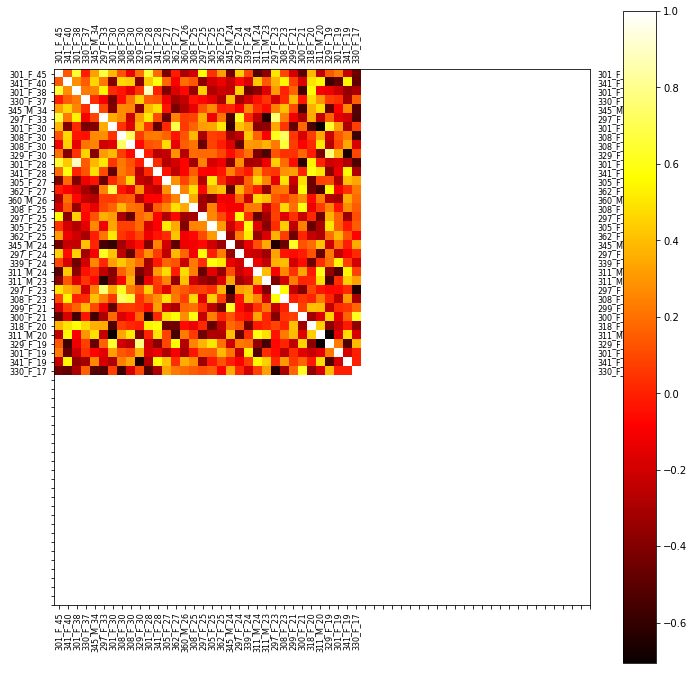

In [22]:
# plot heatmap
max_show = 60
plt.figure(figsize=(12,12))
plt.imshow(cs[:max_show, :max_show], cmap='hot', interpolation='nearest')#, vmin=0.8, vmax=1)
plt.colorbar()
#plt.gca().invert_xaxis()
#plt.gca().invert_yaxis()
plt.xticks(range(max_show))
plt.gca().set_xticklabels(label[:max_show], rotation='vertical')
plt.yticks(range(max_show))
plt.gca().set_yticklabels(label[:max_show])
plt.gca().xaxis.set_tick_params(labeltop='on')
plt.gca().yaxis.set_tick_params(labelright='on')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.show()

In [23]:
embeddings[0:2,:5]

array([[-0.00195038, -0.00466083, -0.00088293, -0.00036297,  0.00151079],
       [-0.00254832, -0.00098857,  0.00024088, -0.00076394,  0.00187193]], dtype=float32)

In [24]:
cs[:,1]

array([ 0.13750391,  1.        ,  0.27518043,  0.15155989,  0.46649036,
        0.2210931 , -0.39875895,  0.47241956,  0.44472805, -0.38719159,
        0.43090361,  0.59102529,  0.18433614, -0.09075553,  0.19518377,
        0.13849984, -0.37277031, -0.19708696, -0.13245325, -0.22683014,
       -0.05664332, -0.17892241,  0.43331781,  0.13392761,  0.37145275,
        0.54269624,  0.0749383 , -0.17493679,  0.49826834,  0.55917257,
       -0.57093233, -0.47103301,  0.54708475, -0.48609158], dtype=float32)

In [25]:
kld = -0.5 * torch.sum(1 + embedding_array_logvar - embedding_array_mu.pow(2) - embedding_array_logvar.exp())

In [26]:
-0.5 * torch.mean(1 + embedding_array_logvar - embedding_array_mu.pow(2) - embedding_array_logvar.exp())

Variable containing:
1.00000e-05 *
  5.4273
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [323]:
kld

Variable containing:
 879.5229
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [324]:
-0.5 * torch.mean(1 + embedding_array_logvar - embedding_array_mu.pow(2) - embedding_array_logvar.exp()) * 64 * 64

Variable containing:
 879.5229
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [325]:
1./(64*64)

0.000244140625

In [27]:
np.sqrt(np.exp(embedding_array_logvar[0,:].data.cpu().numpy()))

array([ 0.98658741,  0.98929423,  0.98855364,  0.98961663,  0.98851544,
        0.98957539,  0.98811257,  0.98586357,  0.98636085,  0.98768765,
        0.98695135,  0.98594064,  0.98819852,  0.98813856,  0.98634094,
        0.98439145,  0.98777878,  0.98686773,  0.98591572,  0.98832035,
        0.98885876,  0.98748624,  0.9866854 ,  0.99002224,  0.98327982,
        0.98897409,  0.98763078,  0.98794198,  0.98914152,  0.98552918,
        0.9820978 ,  0.98875356,  0.98753059,  0.98698658,  0.98247665,
        0.98406905,  0.98932415,  0.98713493,  0.98600435,  0.98467261,
        0.98884773,  0.98830187,  0.98845786,  0.9883604 ,  0.9882623 ,
        0.98427337,  0.99000984,  0.98788017,  0.98810816,  0.98863393,
        0.98803091,  0.98815823,  0.98374754,  0.98874193,  0.98949105,
        0.98187518,  0.9878208 ,  0.98622304,  0.98747385,  0.98534954,
        0.98279977,  0.98714411,  0.98765016,  0.98704714], dtype=float32)

In [28]:
1 + embedding_array_logvar[0,:].data.cpu().numpy() - np.exp(embedding_array_logvar[0,:].data.cpu().numpy())

array([-0.00036144, -0.00023007, -0.00026304, -0.00021636, -0.00026482,
       -0.00021809, -0.00028378, -0.00040156, -0.00037372, -0.00030446,
       -0.00034201, -0.00039721, -0.00027966, -0.00028247, -0.00037485,
       -0.00048983, -0.00029993, -0.00034642, -0.00039864, -0.00027388,
       -0.00024921, -0.00031453, -0.0003562 , -0.00019979, -0.00056231,
       -0.00024408, -0.00030726, -0.000292  , -0.00023669, -0.00042087,
       -0.00064486, -0.00025392, -0.00031227, -0.00034022, -0.0006178 ,
       -0.00051028, -0.00022876, -0.00033242, -0.00039357, -0.00047231,
       -0.00024968, -0.00027478, -0.00026751, -0.00027204, -0.00027663,
       -0.00049728, -0.00020027, -0.00029498, -0.00028396, -0.0002594 ,
       -0.00028765, -0.00028157, -0.0005312 , -0.00025445, -0.00022167,
       -0.00066108, -0.0002979 , -0.00038135, -0.00031513, -0.00043142,
       -0.00059509, -0.00033194, -0.00030631, -0.00033706], dtype=float32)

In [29]:
embedding_array_mu[0,:].data.cpu().numpy()

array([ -1.95038179e-03,  -4.66083363e-03,  -8.82934721e-04,
        -3.62967723e-04,   1.51079101e-03,   1.75010320e-03,
         4.47324803e-03,  -2.72370270e-03,   2.88055977e-04,
         2.73930404e-04,  -2.66008405e-03,   7.02932011e-05,
         4.36642673e-04,  -2.09254125e-04,  -4.03246563e-03,
        -4.70449170e-03,   1.08521280e-03,   4.73469729e-04,
        -1.17457956e-02,   2.17474764e-03,   2.48228549e-04,
        -4.17536404e-03,   3.15349083e-04,   8.72390752e-04,
        -1.74678443e-03,  -2.44897301e-03,  -6.99667353e-03,
        -1.97554240e-03,   1.19531166e-03,  -6.37343619e-03,
         2.25702999e-03,  -3.75604001e-03,  -6.28376729e-04,
        -7.07366178e-03,   1.26614347e-02,  -1.29982233e-02,
        -2.09670863e-03,   9.32802260e-03,   5.23400959e-03,
         1.09935310e-02,  -4.53356514e-03,   1.14320556e-03,
        -2.01342115e-03,  -3.55062471e-03,   1.31636823e-03,
        -2.16340236e-02,   4.80054237e-04,  -1.83586788e-03,
         3.28597752e-03,

In [329]:
embeddings.shape

(34, 64)

In [330]:
embedding_array_mu - embedding_array_mu.mean(dim=0)

Variable containing:
 0.3348 -0.3939 -0.0765  ...   0.1897  1.2186  0.5981
 0.0191  0.2783  0.0112  ...  -0.3278 -0.0929 -0.0826
-0.0432  0.4020 -0.1485  ...   0.5984 -0.1135  0.2890
          ...             ⋱             ...          
 0.0765  0.1682 -0.1145  ...  -0.7144 -0.2807  0.2211
-0.0101  0.0465  0.0194  ...   0.1478  0.0115 -0.2595
 0.0260  0.1307 -0.0950  ...   0.2315 -0.4371 -0.0992
[torch.cuda.FloatTensor of size 64x64 (GPU 0)]

In [331]:
tmp = (embedding_array_mu - embedding_array_mu.mean(dim=0)).data.cpu().numpy()

In [332]:
np.flatnonzero(np.abs(tmp).mean(axis=1) > 1e-9)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

In [333]:
e = embedding_array_mu.data.cpu().numpy()

In [334]:
tmp = (embeddings - embeddings.mean(axis=0))

In [335]:
np.flatnonzero(np.abs(tmp).mean(axis=1) > 1e-9)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [30]:
c = np.corrcoef(embeddings)

In [31]:
c

array([[ 1.        ,  0.1295773 ,  0.64718315, ...,  0.24135918,
        -0.22404977, -0.4455235 ],
       [ 0.1295773 ,  1.        ,  0.26889908, ..., -0.46921789,
         0.54754994, -0.48374625],
       [ 0.64718315,  0.26889908,  1.        , ..., -0.20209788,
        -0.3620374 , -0.29172416],
       ..., 
       [ 0.24135918, -0.46921789, -0.20209788, ...,  1.        ,
        -0.18468346, -0.01028289],
       [-0.22404977,  0.54754994, -0.3620374 , ..., -0.18468346,
         1.        , -0.00228927],
       [-0.4455235 , -0.48374625, -0.29172416, ..., -0.01028289,
        -0.00228927,  1.        ]])

In [32]:
c.mean()

0.06323437188762876

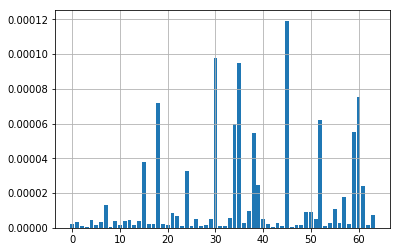

In [33]:
plt.bar(range(64), np.mean(embeddings**2, axis=0))
plt.grid(True)
plt.show()

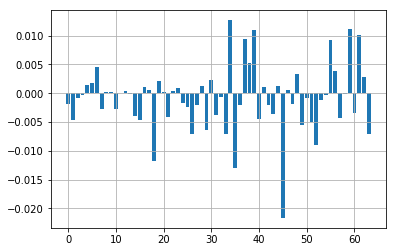

In [34]:
plt.bar(range(64), embeddings[0,:])
plt.grid(True)
plt.show()

In [35]:
np.sqrt(np.mean(embeddings**2, axis=1))

array([ 0.00570753,  0.00363942,  0.00793267,  0.00464551,  0.00577746,
        0.00586922,  0.00494474,  0.00294332,  0.0028811 ,  0.0035284 ,
        0.00421129,  0.00259206,  0.00330235,  0.00515619,  0.00329252,
        0.00241446,  0.00334402,  0.00293335,  0.00359302,  0.00421729,
        0.00377649,  0.00364852,  0.00230201,  0.00436593,  0.00399525,
        0.00240872,  0.00282657,  0.00267434,  0.00421818,  0.00283446,
        0.00392919,  0.00320868,  0.00251431,  0.00201765], dtype=float32)

So the embeddings are all getting pushed very close to the origin, but with large variance? Does that sound right?

In [36]:
np.sqrt(np.mean(np.random.randn(10,256)**2, axis=1))

array([ 0.98757287,  0.94931385,  1.02512882,  0.98313676,  1.0330111 ,
        0.96528348,  0.92191262,  0.92821785,  1.09565444,  1.05125757])

In [37]:
# t-sne
tsne = TSNE(n_components=2)
tsne_fit = tsne.fit_transform(embeddings)

In [38]:
idx_m = [b == 'M' for b in batch_spkr_gender]
idx_f = [b == 'F' for b in batch_spkr_gender]

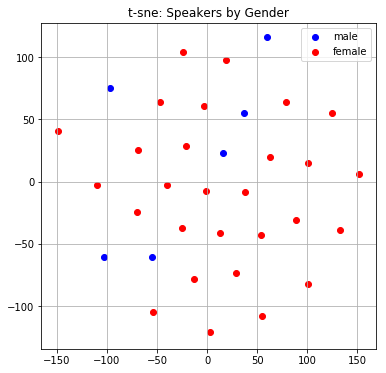

In [39]:
plt.figure(figsize=(6,6))
m_plot = plt.scatter(tsne_fit[idx_m, 0], tsne_fit[idx_m, 1], c='b', label='male')
f_plot = plt.scatter(tsne_fit[idx_f, 0], tsne_fit[idx_f, 1], c='r', label='female')
leg = plt.legend(handles=[m_plot, f_plot])
plt.grid(True)
plt.title('t-sne: Speakers by Gender')
plt.show()

In [40]:
# PCA
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(embeddings)

In [41]:
pca.explained_variance_

array([ 0.00027112,  0.00021941], dtype=float32)

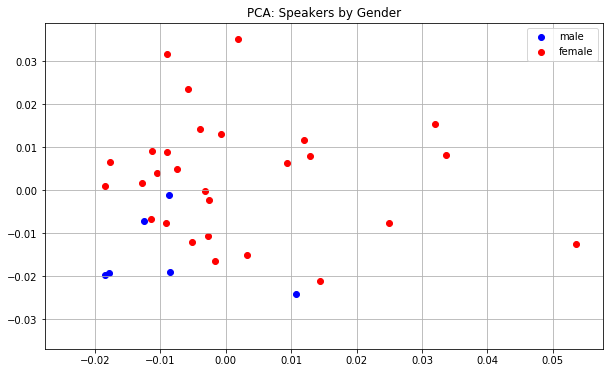

In [42]:
plt.figure(figsize=(10,6))
m_plot = plt.scatter(pca_fit[idx_m, 0], pca_fit[idx_m, 1], c='b', label='male')
f_plot = plt.scatter(pca_fit[idx_f, 0], pca_fit[idx_f, 1], c='r', label='female')
leg = plt.legend(handles=[m_plot, f_plot])
plt.grid(True)
plt.title('PCA: Speakers by Gender')
plt.show()

In [43]:
e_mean_m = np.zeros((64,1))
e_mean_f = np.zeros((64,1))
for i in range(64):
    e_mean_m[i] = embeddings[idx_m, i].mean()
    e_mean_f[i] = embeddings[idx_f, i].mean()

    

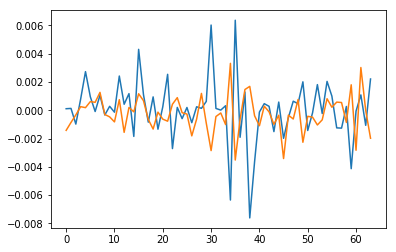

In [44]:
plt.plot(range(64), np.hstack([e_mean_m, e_mean_f]))

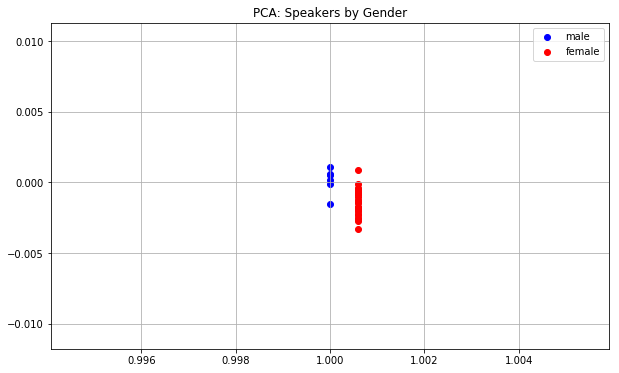

In [45]:
##### 
dim_idx = 0
plt.figure(figsize=(10,6))
m_plot = plt.scatter(np.ones(sum(idx_m)), embeddings[idx_m, dim_idx], c='b', label='male')
f_plot = plt.scatter(np.ones(sum(idx_f))+6e-4, embeddings[idx_f, dim_idx], c='r', label='female')
leg = plt.legend(handles=[m_plot, f_plot])
plt.grid(True)
plt.title('PCA: Speakers by Gender')
plt.show()

In [46]:
embeddings[idx_m, dim_idx].mean()


0.00010692805

In [47]:
hist, bin_edges = np.histogram(embeddings[:, dim_idx], bins=10)
hist_m, _ = np.histogram(embeddings[idx_m, dim_idx], bins=bin_edges)
hist_f, _ = np.histogram(embeddings[idx_f, dim_idx], bins=bin_edges)

In [48]:
t = np.vstack([hist_m.reshape([1, len(hist)]), hist_f.reshape([1, len(hist)])])

In [49]:
t

array([[0, 0, 0, 0, 1, 0, 0, 1, 3, 1],
       [1, 3, 3, 6, 4, 5, 4, 1, 0, 1]])

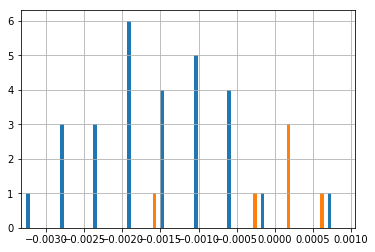

In [50]:
plt.bar(bin_edges[:-1]+1e-4, hist_f, width=5e-5)
plt.bar(bin_edges[:-1], hist_m, width=5e-5)
plt.xlim(min(bin_edges), max(bin_edges))
plt.grid()
plt.show()   

In [204]:
np.vstack([hist_m.reshape([1, len(hist)]), hist_f.reshape([1, len(hist)])]).shape

(2, 10)

In [205]:
model.train()
model.reparameterize(embedding_array_mu, embedding_array_logvar)

Variable containing:
 0.4399 -1.9023  1.5638  ...   0.2837  2.2873 -0.4740
 0.2435  0.7784  0.3395  ...  -0.4520  0.5830 -0.6359
-0.3497 -0.2491  0.4791  ...   0.4965  0.6768  0.4916
          ...             ⋱             ...          
-0.1447 -0.1343 -1.4584  ...  -0.2659 -0.8581 -0.4269
 0.0781  0.4903 -0.2368  ...   0.0156 -0.2597 -0.4968
-0.0116 -0.4573  0.7001  ...   0.1140 -0.5266 -0.2067
[torch.cuda.FloatTensor of size 64x64 (GPU 0)]

In [77]:
#313_245
#'checkpoints/vctk-us-vae-kl-anneal-notanhrenorm-lambda0.01/bestmodel.pth',
out_dict = nu.generate_sample_with_loop(npz='p311_004.npz', text="Gives reliable, long-lasting panic.", spkr_id=10, gender=1,
                              checkpoint='checkpoints/vctk-us-vae-64-mean-lambda-5-noise-2/bestmodel.pth',
                              output_dir='./',
                              npz_path='/home/ubuntu/loop/data/vctk/numpy_features',
                              is_vctk_22=True,
                              output_file_override='test',
                              embedding_array=None,
                              b_reparam_ident=False)

Gives reliable, long-lasting panic.
False
torch.Size([745, 1, 63])
torch.Size([745, 1, 63])
complete test.wav.
complete p311_004.orig.wav.


In [52]:
IPython.display.display(Audio(out_dict['output_orig_fname'] + '.wav', autoplay=True))

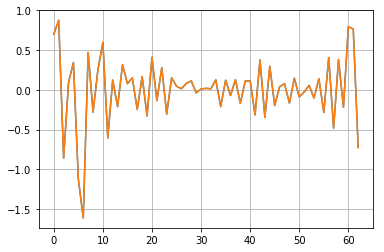

In [78]:
IPython.display.display(Audio(out_dict['output_file'] + '.wav', autoplay=True))
plt.plot(out_dict['loop_feat'][61,0,:]); plt.plot(old_dict['loop_feat'][61,0,:]); plt.grid(True); plt.show()

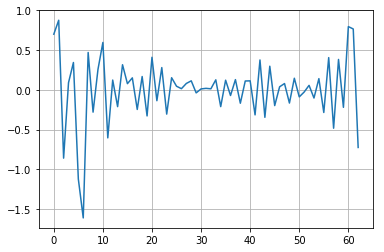

In [74]:
IPython.display.display(Audio(out_dict['output_file'] + '.wav', autoplay=True))
plt.plot(out_dict['loop_feat'][61,0,:]); plt.grid(True); plt.show()
old_dict = out_dict.copy()

**Note** Run these through a speaker recogniser to prove that the outputs aren't recognisable as the speaker they say they are

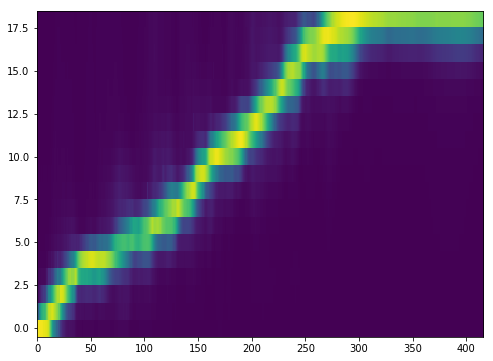

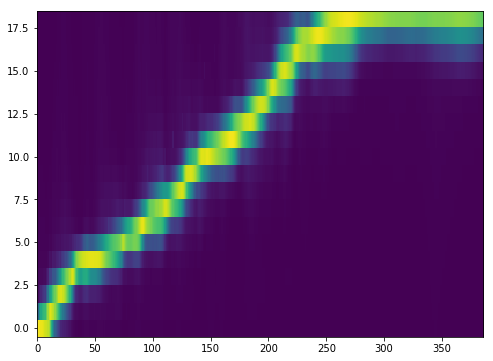

In [377]:
import matplotlib.cm as cm

plt.figure(figsize=(8, 6))
axarr = plt.subplot()
axarr.imshow(out_dict['attn'].T, aspect='auto', origin='lower', interpolation='nearest', cmap=cm.viridis)
#axarr.set_yticks(np.arange(0, len(data.T)))

plt.figure(figsize=(8, 6))
axarr = plt.subplot()
axarr.imshow(old_dict['attn'].T, aspect='auto', origin='lower', interpolation='nearest', cmap=cm.viridis)
#axarr.set_yticks(np.arange(0, len(data.T)))
#axarr.set_yticklabels(labels, rotation=90)
    

In [118]:
out_dict.keys()

['output_orig_fname',
 'spkr',
 'output_file',
 'pre_calc_feat',
 'loop_feat',
 'valid_dataset_path',
 'attn',
 'txt',
 'feat']

In [55]:
IPython.display.display(Audio(out_dict['output_file'] + '.wav', autoplay=True))

In [51]:
IPython.display.display(Audio(out_dict['output_file'] + '.wav', autoplay=True))

so the vctk-us-vae-kl-anneal-test sim (which ends up with KLD -> 0) ends up just learning an average voice, really, with all the embedding mu values very close to zero, and the variances all equal to 1. In eval mode we always use the mu and the samples for differenet input feats sound identical (although they're not strictly identical, I guess.) In train mode, it samples the embedding and we do get a very small amount of variation in the sample - but you have to really try to hear the differences! It's not really using the embedding space at all - samples sound very similar even if you really mess with the variance and make it huge. If I multiply the mu by 1e5 or something we do actually manage to recover speech that sounds more similar to the original speakers - so the embeddings are miles outside the high probability region?? Or they're in there somewhere but the KLD hurts too much so they get ignored



In [112]:
speaker_info[speaker_info.accents=='American']

,id,age,gender,accents,region
294,294,33,F,American,San Francisco
297,297,20,F,American,New York
299,299,25,F,American,California
300,300,23,F,American,California
301,301,23,F,American,North Carolina
305,305,19,F,American,Philadelphia
306,306,21,F,American,New York
308,308,18,F,American,Alabama
310,310,21,F,American,Tennessee
311,311,21,M,American,Iowa
